In [52]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import optuna
import shap

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder                      

In [53]:

folder_path = 'S_TC-figure'

# 检查文件夹是否存在，如果不存在则创建它
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹 {folder_path} 已创建。")     

In [54]:
df = pd.read_csv("S_TC_填充.csv",  dtype={'DIPOCE': str, 'BA_Code': str, 'Cata_Code': str})
df

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,R,CHS,AB_Mix_t,Q,Cata_Code,MCS,TC_Method,TC_T,Closed_CC,S_TC
0,110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,1.83,59.700000,5.14,0.0,100000,108.600,1,283.15,90.8,0.661957
1,100010000,31.5,440.000000,3.513788,1000,18.0,50.676157,1.494662,1.010676,0.455516,...,1.10,58.400000,10.00,0.0,100100,310.000,1,297.15,88.9,0.736923
2,100100100,31.5,429.326712,3.418639,1000,18.0,32.931727,0.975330,0.659782,0.295468,...,1.10,63.500000,10.00,0.0,100100,220.000,1,297.15,89.9,0.763830
3,100100100,31.5,418.118624,3.566900,1000,18.0,30.906059,0.990550,0.617009,0.278488,...,1.10,64.600000,10.00,0.0,100100,210.000,1,297.15,84.2,0.928247
4,100100100,31.5,406.184223,3.560246,1000,18.0,29.056604,0.862534,0.582210,0.264151,...,1.10,65.000000,10.00,0.0,100100,280.000,1,297.15,68.9,0.989474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,100010000,31.0,416.000000,2.000000,1000,18.0,73.421439,2.276065,1.101322,0.367107,...,1.10,57.662997,5.00,48.0,100000,302.422,1,283.15,20.4,0.979101
284,100010000,31.0,416.000000,2.000000,1000,18.0,80.515298,1.328502,1.207729,0.402576,...,1.10,55.396967,5.00,48.0,100000,266.180,1,283.15,15.9,0.668793
285,100010000,31.0,416.000000,2.000000,1000,18.0,84.104289,0.849453,1.261564,0.420521,...,1.10,54.317040,5.00,48.0,100000,263.662,1,283.15,19.5,0.488807
286,100010000,31.0,416.000000,2.000000,1000,18.0,85.251492,0.699062,1.278772,0.426257,...,1.10,53.980672,5.00,48.0,100000,243.812,1,283.15,34.5,0.414447


In [55]:
pad_lengths = {
    'DIPOCE': 10,    # 9位
    'BA_Code': 4,   # 4位
    'Cata_Code': 6  # 6位
}

for col, length in pad_lengths.items():
    df[col] = df[col].astype(str).str.zfill(length)
df

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,R,CHS,AB_Mix_t,Q,Cata_Code,MCS,TC_Method,TC_T,Closed_CC,S_TC
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,1.83,59.700000,5.14,0.0,100000,108.600,1,283.15,90.8,0.661957
1,0100010000,31.5,440.000000,3.513788,1000,18.0,50.676157,1.494662,1.010676,0.455516,...,1.10,58.400000,10.00,0.0,100100,310.000,1,297.15,88.9,0.736923
2,0100100100,31.5,429.326712,3.418639,1000,18.0,32.931727,0.975330,0.659782,0.295468,...,1.10,63.500000,10.00,0.0,100100,220.000,1,297.15,89.9,0.763830
3,0100100100,31.5,418.118624,3.566900,1000,18.0,30.906059,0.990550,0.617009,0.278488,...,1.10,64.600000,10.00,0.0,100100,210.000,1,297.15,84.2,0.928247
4,0100100100,31.5,406.184223,3.560246,1000,18.0,29.056604,0.862534,0.582210,0.264151,...,1.10,65.000000,10.00,0.0,100100,280.000,1,297.15,68.9,0.989474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0100010000,31.0,416.000000,2.000000,1000,18.0,73.421439,2.276065,1.101322,0.367107,...,1.10,57.662997,5.00,48.0,100000,302.422,1,283.15,20.4,0.979101
284,0100010000,31.0,416.000000,2.000000,1000,18.0,80.515298,1.328502,1.207729,0.402576,...,1.10,55.396967,5.00,48.0,100000,266.180,1,283.15,15.9,0.668793
285,0100010000,31.0,416.000000,2.000000,1000,18.0,84.104289,0.849453,1.261564,0.420521,...,1.10,54.317040,5.00,48.0,100000,263.662,1,283.15,19.5,0.488807
286,0100010000,31.0,416.000000,2.000000,1000,18.0,85.251492,0.699062,1.278772,0.426257,...,1.10,53.980672,5.00,48.0,100000,243.812,1,283.15,34.5,0.414447


In [56]:

y = df['S_TC']

X = df.drop(["S_TC"], axis=1)
X

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,Yield,R,CHS,AB_Mix_t,Q,Cata_Code,MCS,TC_Method,TC_T,Closed_CC
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,96.884711,1.83,59.700000,5.14,0.0,100000,108.600,1,283.15,90.8
1,0100010000,31.5,440.000000,3.513788,1000,18.0,50.676157,1.494662,1.010676,0.455516,...,97.017857,1.10,58.400000,10.00,0.0,100100,310.000,1,297.15,88.9
2,0100100100,31.5,429.326712,3.418639,1000,18.0,32.931727,0.975330,0.659782,0.295468,...,97.377587,1.10,63.500000,10.00,0.0,100100,220.000,1,297.15,89.9
3,0100100100,31.5,418.118624,3.566900,1000,18.0,30.906059,0.990550,0.617009,0.278488,...,97.428971,1.10,64.600000,10.00,0.0,100100,210.000,1,297.15,84.2
4,0100100100,31.5,406.184223,3.560246,1000,18.0,29.056604,0.862534,0.582210,0.264151,...,97.478380,1.10,65.000000,10.00,0.0,100100,280.000,1,297.15,68.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0100010000,31.0,416.000000,2.000000,1000,18.0,73.421439,2.276065,1.101322,0.367107,...,96.859603,1.10,57.662997,5.00,48.0,100000,302.422,1,283.15,20.4
284,0100010000,31.0,416.000000,2.000000,1000,18.0,80.515298,1.328502,1.207729,0.402576,...,98.229830,1.10,55.396967,5.00,48.0,100000,266.180,1,283.15,15.9
285,0100010000,31.0,416.000000,2.000000,1000,18.0,84.104289,0.849453,1.261564,0.420521,...,98.887437,1.10,54.317040,5.00,48.0,100000,263.662,1,283.15,19.5
286,0100010000,31.0,416.000000,2.000000,1000,18.0,85.251492,0.699062,1.278772,0.426257,...,99.089386,1.10,53.980672,5.00,48.0,100000,243.812,1,283.15,34.5


In [57]:
X.describe()

,DI_NCO,PO_HV,PO_f,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,f(H2O),M_loss,Yield,R,CHS,AB_Mix_t,Q,MCS,TC_Method,TC_T,Closed_CC
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,31.458061,450.132960,4.878729,35.235099,64.800164,5.319284,1.557871,1.178769,0.139333,8.741026,94.226860,1.205019,60.891931,12.238854,110.568090,310.419337,1.322917,296.545417,75.389241
std,0.623216,162.294846,2.172546,35.236685,19.944942,7.302023,0.493237,0.851644,0.077325,9.971527,6.502266,0.264867,7.498789,6.046251,238.204992,170.138122,0.771822,11.993047,22.227029
min,30.000000,211.000000,2.000000,0.000000,1.000000,0.000000,0.399489,0.000000,0.000000,0.000000,64.652956,0.800000,32.800000,5.000000,-48.000000,20.000000,0.000000,283.150000,9.000000
25%,31.000000,368.260870,3.499144,18.000000,52.427052,1.400000,1.261381,0.700000,0.097153,3.783430,94.596087,1.100000,55.918451,8.000000,0.000000,204.750000,1.000000,292.922500,71.754800
50%,31.376500,420.500000,4.465955,18.000000,62.970529,2.036492,1.540306,1.057000,0.130173,4.921485,96.801430,1.100000,61.422144,10.000000,9.519000,261.448000,1.000000,295.325000,83.571000
75%,31.500000,473.183938,6.000000,31.430089,77.396986,3.405016,1.841889,1.488515,0.180124,8.005650,97.699996,1.250000,65.000000,15.000000,87.040475,392.250000,1.000000,298.150000,89.755050
max,33.600000,1365.168399,16.000000,148.100000,126.000000,30.500000,4.300000,4.250000,0.278000,68.750000,100.000000,2.400000,76.784678,30.000000,1368.000000,900.000000,3.000000,343.150000,99.000000


In [58]:
params = {'iterations':1400,
            'depth': 5,
            'learning_rate': 0.020,
            'l2_leaf_reg': 4.6,
            'bagging_temperature': 0.46,
            'border_count': 179,
      }

In [59]:
cb_params = params

In [60]:
# 定义评估函数（无 RSE）
def evaluate_model(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return  mae, mse, rmse
# 存储每一折的结果
results = []

# 设置 KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

predictions = []
actuals = []
indices = []

n_features = X.shape[1]

# 交叉验证主循环
for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostRegressor(**cb_params, verbose=0, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_pred_train = model.predict(X_train)

    predictions.append(y_pred_val)
    actuals.append(y_val)
    indices.append(y_val.index)

    mae_train, mse_train, rmse_train = evaluate_model(y_train, y_pred_train, n_features)
    mae_val, mse_val, rmse_val = evaluate_model(y_val, y_pred_val, n_features)
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)

    results.append({
        'Fold': fold,
        'r2_train': r2_train,
        'r2_val': r2_val,
        'mae_train': mae_train,
        'mae_val': mae_val,
        'mse_train': mse_train,
        'mse_val': mse_val,
        'rmse_train': rmse_train,
        'rmse_val': rmse_val
    })

# 结果汇总
df_results = pd.DataFrame(results)

# 添加平均行
mean_results = df_results.mean(numeric_only=True)
mean_results['Fold'] = 'Mean'
df_results = pd.concat([df_results, pd.DataFrame([mean_results])], ignore_index=True)
# 合并预测、实际值、索引
all_predictions = np.concatenate(predictions)
all_actuals = np.concatenate(actuals)
all_indices = np.concatenate(indices)

# 输出评估结果表格
df_results


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12084\2717953535.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_results['Fold'] = 'Mean'


,Fold,r2_train,r2_val,mae_train,mae_val,mse_train,mse_val,rmse_train,rmse_val
0,1,0.995427,0.860427,0.018119,0.074986,0.000540,0.012295,0.023239,0.110881
1,2,0.995374,0.865011,0.017913,0.084460,0.000496,0.014835,0.022270,0.121799
2,3,0.990403,0.853970,0.024761,0.089692,0.000950,0.018445,0.030823,0.135811
3,Mean,0.993735,0.859802,0.020264,0.083046,0.000662,0.015191,0.025444,0.122830


In [61]:
# 计算每个指标的均值 ± 标准差
cols = df_results.drop('Fold', axis=1).columns
mean = df_results[cols].mean()
std = df_results[cols].std()
result = mean.round(2).astype(str) + ' ± ' + std.round(2).astype(str)

# 输出结果
print(result)

r2_train       0.99 ± 0.0
r2_val         0.86 ± 0.0
mae_train      0.02 ± 0.0
mae_val       0.08 ± 0.01
mse_train       0.0 ± 0.0
mse_val        0.02 ± 0.0
rmse_train     0.03 ± 0.0
rmse_val      0.12 ± 0.01
dtype: object


In [62]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 用训练集训练模型
final_model = CatBoostRegressor(**cb_params, verbose=0, random_state=42)
final_model.fit(X_train, y_train)

# 预测训练集和测试集
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# 计算评估指标函数
def evaluate(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return r2, mae, rmse

n_features = X.shape[1]
r2_train,  mae_train, rmse_train = evaluate(y_train, y_pred_train, n_features)
r2_test,  mae_test, rmse_test = evaluate(y_test, y_pred_test, n_features)

# 打印结果
print("训练集指标：")
print(f"R²: {r2_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}")
print("测试集指标：")
print(f"R²: {r2_test:.2f},  MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}")


训练集指标：
R²: 0.99, MAE: 0.02, RMSE: 0.02
测试集指标：
R²: 0.86,  MAE: 0.08, RMSE: 0.12


In [63]:
import joblib

# 保存模型到本地（.joblib格式）
joblib.dump(final_model, "F:/codes/00-WORK/work-1/01-myself/01-predict/01-model/S_TC.joblib")  
np.save("F:/codes/00-WORK/work-1/01-myself/01-predict/01-plot/S_TC.npy", y.to_numpy()) 

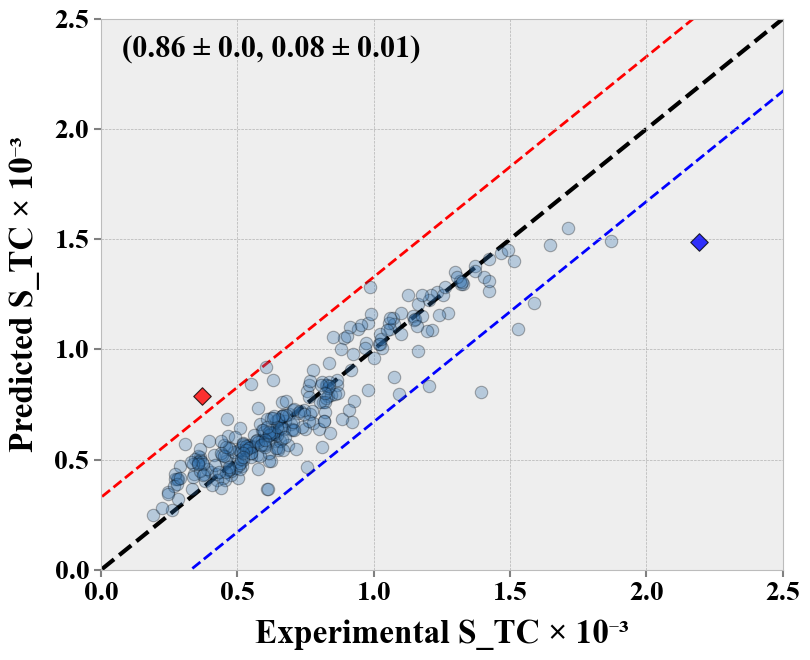

In [64]:
# 计算误差
errors = np.abs(all_predictions - all_actuals)

# 按误差降序排序索引（最大误差在最后）
sorted_idx = np.argsort(errors)

# 指定你要高亮的“误差排名”
selected_ranks = [0, 3] 

# 获取对应的点索引（去重）
highlight_idx = list({sorted_idx[-(r + 1)] for r in selected_ranks})

# 其他点索引
others_idx = np.setdiff1d(np.arange(len(all_actuals)), highlight_idx)

# 构建理想线
sigma = np.std(all_actuals)
# 构建理想线的x和y值
min_val = min(all_actuals.min(), all_predictions.min())
max_val = max(all_actuals.max(), all_predictions.max())
# 设置理想线和偏差带用的横坐标范围，覆盖整个图像范围
x_vals = np.linspace(min_val - 20, max_val + 20, 100)
y_vals = x_vals
ci_upper = y_vals + 1.0 * sigma
ci_lower = y_vals - 1.0 * sigma

# 绘图
plt.figure(figsize=(8.5, 7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.style.use('bmh')

# 偏差带线和理想线
plt.plot(x_vals, ci_upper, color='red', linestyle='--', linewidth=2, zorder=1, label='±1.5σ upper')
plt.plot(x_vals, ci_lower, color='blue', linestyle='--', linewidth=2, zorder=1, label='±1.5σ lower')
plt.plot(x_vals, y_vals, 'k--', lw=3, zorder=1, label='Ideal: y = x')

# 画其他点（不在top3）
plt.scatter(all_actuals[others_idx], all_predictions[others_idx],
            alpha=0.3, marker='o', color='#3574B1', edgecolors='black',
            linewidths=0.8, s=80, zorder=2)
# 分别画 highlight_idx 中在上方和下方的点
existing_labels = set()
for i in highlight_idx:
    if all_predictions[i] > all_actuals[i]:
        color = 'red'
        label = 'Top error (above)'
    else:
        color = '#0000FF'
        label = 'Top error (below)'

    # 避免图例重复
    label = label if label not in existing_labels else None
    if label:
        existing_labels.add(label)

    plt.scatter(all_actuals[i], all_predictions[i],
                color=color, marker='D', edgecolors='black', alpha=0.8,
                linewidths=0.8, s=80, zorder=3, label=label)
# R² 和 RMSE 注释
plt.text(0.03, 0.93, f'({result["r2_val"]}, {result["mae_val"]})',
         fontsize=22, transform=plt.gca().transAxes)

# 标签和样式
plt.xlabel('Experimental S_TC × 10⁻³', weight='bold', fontsize=24, fontname='Times New Roman', labelpad=10)
plt.ylabel('Predicted S_TC × 10⁻³', weight='bold', fontsize=24, fontname='Times New Roman', labelpad=10)
plt.xticks(fontsize=20, weight='bold', )
plt.yticks(fontsize=20, weight='bold')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1.5, color='gray', bottom=True, top=False, left=True, right=False)

plt.xlim(0, 2.5)
plt.ylim(0, 2.5)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'S_TC-预测图.png'), dpi=600, bbox_inches='tight')
plt.show()

In [65]:
df_errors = pd.DataFrame({
    'Index': all_indices,
    'Actual': all_actuals,
    'Predicted': all_predictions
})
df_errors['Residuals'] = df_errors['Actual'] - df_errors['Predicted']
df_errors['Abs_Residuals'] = np.abs(df_errors['Residuals'])

# 排序
df_sorted = df_errors.sort_values(by='Abs_Residuals', ascending=False)
df_sorted.head(20)

,Index,Actual,Predicted,Residuals,Abs_Residuals
259,199,2.192513,1.487487,0.705026,0.705026
133,126,1.394422,0.809141,0.585282,0.585282
1,6,1.528794,1.092667,0.436126,0.436126
67,202,0.369198,0.788460,-0.419262,0.419262
258,198,1.871921,1.491151,0.380770,0.380770
196,13,1.588785,1.209654,0.379131,0.379131
234,121,1.202765,0.833343,0.369422,0.369422
2,9,0.605960,0.918495,-0.312535,0.312535
173,230,0.986805,1.285258,-0.298453,0.298453
134,127,1.093548,0.797217,0.296332,0.296332


In [66]:
df_top_actual = df.loc[df_sorted['Index'].head(15)]
df_top_actual

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,R,CHS,AB_Mix_t,Q,Cata_Code,MCS,TC_Method,TC_T,Closed_CC,S_TC
199,0110010000,31.40,668.110236,6.142520,1000,18.000000,81.559416,1.631188,0.407797,0.815594,...,1.100,55.078388,12.00,141.84038,101000,290.000,1,298.15,50.0400,2.192513
126,1010000000,33.60,462.267977,6.827335,1000,18.000000,46.342806,1.627264,1.847557,0.870554,...,1.500,68.853621,15.00,0.00000,100000,206.240,1,298.15,71.5547,1.394422
6,0100100100,31.50,380.000000,3.668265,1000,18.000000,25.826131,0.762583,0.518556,0.234875,...,1.100,66.300000,10.00,0.00000,100100,260.000,1,297.15,37.3000,1.528794
202,0100010000,31.40,495.000000,6.000000,1000,18.000000,84.434500,1.688690,0.422173,1.477604,...,1.300,54.219791,10.00,336.00000,100000,103.000,1,298.15,79.9700,0.369198
198,0110010000,31.40,607.608319,5.516638,1000,18.000000,80.886516,1.617730,0.404433,0.808865,...,1.100,55.283280,12.00,144.20519,101000,275.000,1,298.15,75.7100,1.871921
13,0101010000,31.40,444.495963,3.576715,1000,18.000000,66.000000,2.000000,1.650000,0.700000,...,1.100,55.500000,10.46,0.00000,101000,237.300,1,298.15,47.0000,1.588785
121,0100100000,31.00,420.000000,6.000000,1001,24.119355,37.000000,2.241000,1.500000,1.480000,...,2.000,73.000000,10.00,888.00000,011000,110.000,1,283.15,82.0000,1.202765
9,0110000000,31.25,430.000000,4.100000,1000,18.000000,74.100000,1.500000,1.500000,3.340000,...,1.182,57.400000,10.79,342.00000,101001,350.000,1,290.55,66.0000,0.605960
230,0110100000,32.50,370.349080,6.251151,1000,18.000000,35.971223,1.798561,1.798561,1.366906,...,1.100,73.544974,7.00,85.66228,101000,331.529,1,323.15,53.2690,0.986805
127,1010010000,33.60,458.819114,6.949169,1000,18.000000,46.851986,1.648001,1.928023,0.871832,...,1.500,68.528705,15.00,0.00000,100000,205.000,1,298.15,74.5278,1.093548


In [67]:
df = pd.read_csv("S_TC_填充.csv")
X = df.drop(["S_TC"], axis=1)
# 创建一个SHAP解释器
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, check_additivity=False)
shap_values

array([[ 2.21966341e-02,  2.96429309e-03,  1.56159432e-02, ...,
         1.48673891e-03, -1.00988418e-02, -7.88590831e-02],
       [-1.47139749e-02,  1.14493864e-03, -7.01611736e-03, ...,
         3.21933128e-03,  1.71807937e-02, -9.69458027e-02],
       [-9.27932941e-03,  2.25458324e-03, -2.18367305e-04, ...,
         3.41329031e-03,  1.95177135e-02, -9.79013101e-02],
       ...,
       [-1.30310823e-02, -1.38073132e-03,  5.86103555e-03, ...,
         4.20514093e-05, -3.09252933e-02,  1.53649729e-01],
       [-1.30529884e-02, -3.42247945e-03,  3.81782748e-03, ...,
         2.16031116e-05, -3.00187510e-02,  1.39903823e-01],
       [-1.08157060e-02, -2.72306476e-03,  2.61089537e-03, ...,
         5.60936819e-05, -2.61966006e-02,  1.33952094e-01]],
      shape=(288, 22))

In [68]:
import shap
import os
import matplotlib.pyplot as plt

# 设置字体和样式
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('default')

# 创建主图
fig, ax1 = plt.subplots(figsize=(10, 8), dpi=1200)

# 蜂巢图（dot plot）
feature_names = [name.replace("f(H2O)", r"f(H$_2$O)") for name in X.columns]
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="dot", show=False, color_bar=False, max_display=22)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 调整位置为主图 ax1
ax1 = plt.gca()

# 顶部条形图（bar plot）
ax2 = ax1.twiny()
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar", show=False, max_display=22)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 确保对齐
for bar in ax2.patches:
    # bar.set_facecolor("skyblue")
    bar.set_alpha(0.2)

# 添加灰色参考线
ax2.axhline(y=22, color='black', linestyle='-', linewidth=2)

# 坐标轴标签设置,新罗马字体
ax1.set_xlabel('Shapley Value Contribution', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')
ax1.set_ylabel('Features', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')

ax2.set_xlabel('Mean (|Shapley Value|)', fontsize=22, labelpad=10, weight='bold', fontname='Times New Roman')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()

# 设置刻度字体大小和粗细
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')

for label in ax2.get_xticklabels():
    label.set_fontsize(18)
    label.set_fontweight('bold')
    label.set_fontname('Times New Roman')
# 边框
for spine in ['left',  'bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_edgecolor('black')
    ax1.spines[spine].set_linewidth(1.5)

# 刻度线
ax1.tick_params(axis='both', direction='out', colors='black', width=1.5, length=5)
ax2.tick_params(axis='x', direction='out', colors='black', width=1.5, length=5)
# ax1.set_xlim(-0.18, 0.16)
ax2.set_xlim(0, 0.082)
# ax1.set_xticks(np.linspace(-0.15, 0.15, 5))
ax2.set_xticks(np.linspace(0, 0.08, 5))

# 调整排版，保存并展示
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'TC_SHAP.png'), dpi=600, bbox_inches='tight')
plt.show()
